In [ ]:
# Check S3 connection directory
!ls /datasets/shopee-week2

shopee-product-detection-dataset.zip


In [ ]:
# initiate config file to initiate hyper parameters
import configparser
config = configparser.ConfigParser()
config.read('param_list.ini')
for key, val in config['DEFAULT'].items():
    exec(f"{key} = {val}")

In [ ]:
!pip install -q efficientnet

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import glob
from time import time
%matplotlib inline

import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB4, EfficientNetB7
from sklearn.utils.class_weight import compute_class_weight


physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("Tensorflow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("Is using GPU?", gpus)

tf.config.experimental.set_memory_growth(gpus[0], True)

Tensorflow version: 2.2.0
Is using GPU? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import and organize files

In [ ]:
# Check if the zip file has been extracted. Otherwise, extract from S3 connection
copyflag=False
if not (os.path.isdir("train/train") and os.path.isdir("test/test")):
    with zipfile.ZipFile("/datasets/shopee-week2/shopee-product-detection-dataset.zip", "r") as zfile:
        zfile.extractall(".")
    copyflag=True
# #
# get path return generator of files
def files(path):
    '''
    Return generator of files in a given path

    argument: path
    return: file
    '''
    
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)):
            yield f
# if there are still subfolders, move them to the train folder
if copyflag: # do moving only if the files are freshly extracted
    for dirpath, dirnames, filenames in os.walk("train/train", topdown=False):
        # walh through the training folder
        if dirnames: # if folder exists
            for d in dirnames:
                for f in files(d): # move all files inside folder to training folder
                    os.replace(os.path.join(d, f), os.path.join("train/train", f))

# remove empty folders after moving
def drop_empty_folders(path):
    '''
    remove empty subfolders in a given path

    argument: path
    return: none
    '''
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        if not dirnames and not filenames:
            os.rmdir(dirpath)
drop_empty_folders("train/train")


# # check number of extracted files
train_files = os.listdir("train/train")
test_files = os.listdir("test/test")

df_train = pd.read_csv("train.csv", dtype=str)
df_test = pd.read_csv("test.csv", dtype=str)

# check if number of image files is equal to number of index in csv
print(f"Number of training images: {len(train_files)}")
print(f"Number of training indices: {df_train.shape[0]}")
print(f"Number of testing images: {len(test_files)}")
print(f"Number of testing indices: {df_test.shape[0]}")



Number of training images: 105398
Number of training indices: 105392
Number of testing images: 12192
Number of testing indices: 12186


In [ ]:
def remove_tmp_files(path, img_files):
    '''
    remove files ending with .tmp in a given path

    argument: path, list of filenames
    return: list of filenames
    '''
    print(f"Inspecting path: {path}")
    for f in glob.glob(os.path.join(path, '*.tmp')):
        f = f.rsplit('/')[-1]
        try:
            img_files.remove(f)
            print(f"Removing file: {f}")
        except:
            print(f"Trying to remove non-existing file: {f}")
    return img_files
train_files = remove_tmp_files('train/train', train_files)
test_files = remove_tmp_files('test/test', test_files)

# check again if number of image files is equal to number of index in csv
print(f"Number of training images: {len(train_files)}")
print(f"Number of training indices: {df_train.shape[0]}")
print(f"Number of testing images: {len(test_files)}")
print(f"Number of testing indices: {df_test.shape[0]}")

Inspecting path: train/train
Removing file: b4c1a220fd3a43961017717d953fb4e5.jpgk4d4lnxk.tmp
Removing file: 6b6e7a2db5acf395ee36077808f32e3d.jpgt13z3ib7.tmp
Removing file: 8235bf4e577b890f5a5ecfda00951f84.jpgt3reyw1v.tmp
Removing file: a6f9b9e65c3576a64452961a21678395.jpg95ta80mt.tmp
Removing file: 4af102e634973b11e5ab90cdee121a6d.jpgt0581za2.tmp
Removing file: 4e658733865eebe2461c322a54379e7f.jpg8afrrohw.tmp
Inspecting path: test/test
Number of training images: 105392
Number of training indices: 105392
Number of testing images: 12192
Number of testing indices: 12186


# Get random batch

In [ ]:
image_dir = 'train/train/'
image_size = image_size # [96, 128, 160, 192, 224]

def get_random_batch(df, batch_size=4):
    
    indices = np.random.choice(range(df.shape[0]), batch_size, replace=False)
    x = np.zeros((batch_size, image_size, image_size, 3))
    y = np.zeros((batch_size, 1))
    images = []

    for i, index in enumerate(indices):
        image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, df.loc[index]['filename']), 
                                                        target_size=(image_size,image_size))
        images.append(image)
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = int(df.loc[index]['category'])
    return x, y, images

def display_examples(x, y, p, images, df):

    print('Displaying first 8 examples..')

    if len(images) < 8:
        print('Need at least 8 examples')
        return None

    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if y[i][0]==p[i][0] else 'red'
        plt.xlabel(p[i][0], color=col)
    return plt

Displaying first 8 examples..


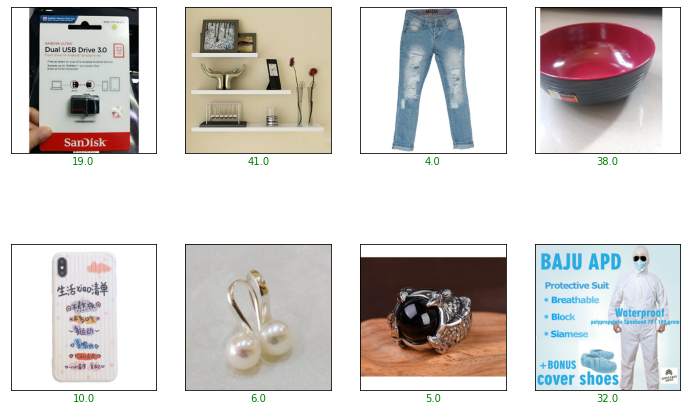

In [ ]:
x, y, images = get_random_batch(df_train, batch_size=8)
display_examples(x, y, y, images, df_train).show()

# Preprocess data


## Get random eraser

In [ ]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Displaying first 8 examples..


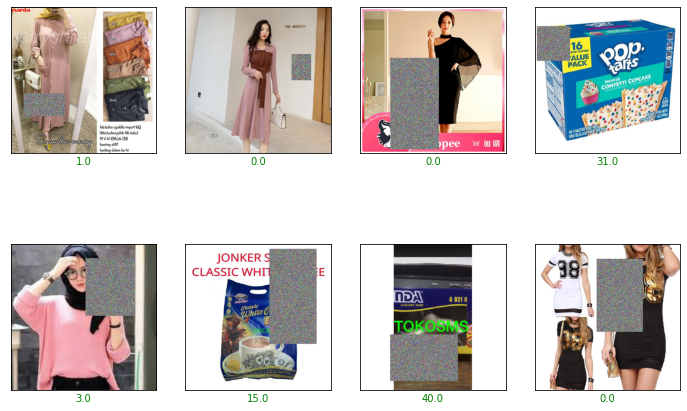

In [ ]:
disp_eraser = get_random_eraser(v_l = 0., v_h = 255., pixel_level=True, p=1)
x, y, images = get_random_batch(df_train, batch_size=8)
display_examples(x, y, y, [disp_eraser(np.array(im)) for im in images], df_train).show()


# Splitting train and val set

In [ ]:
def splitting_data(df, train_ratio=0.9):
    indices = np.random.choice(df.shape[0], int(train_ratio*df.shape[0]), replace=False)
    remaining = set(df.index) - set(indices)
    df_model = df.loc[indices].reset_index()
    df_val = df.loc[remaining].reset_index()
    return df_model, df_val
df_model, df_val = splitting_data(df_train, train_ratio=0.90)
print("Original shape: ", df_train.shape[0])
print("df_model shape: ", df_model.shape[0])
print("df_val shape: ", df_val.shape[0])

Original shape:  105392
df_model shape:  94852
df_val shape:  10540


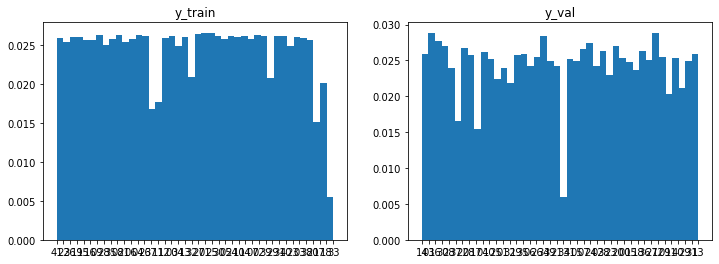

In [ ]:
# compare density of splitting categories
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df_model['category'], density=True, bins=42)
plt.title("y_train")
plt.subplot(1,2,2)
plt.hist(df_val['category'], density=True, bins=42)
plt.title("y_val")
plt.show()

In [ ]:
cat_cols = df_model['category'].unique()
if is_class_weight == True:
    class_weight = compute_class_weight('balanced',
                                        np.unique(df_model['category']),
                                        df_model['category'])
    class_weight = dict(enumerate(class_weight))
else:
    class_weight = {c: 1 for c in range(cat_cols.shape[0])}
class_weight

/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41'], y=0        41
1        22
2        36
3        19
4        15
         ..
94847    20
94848    02
94849    14
94850    06
94851    38
Name: category, Length: 94852, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.932444654162243,
 1: 0.9195362183961533,
 2: 0.9263252470799641,
 3: 0.938645449867395,
 4: 0.927847556442462,
 5: 0.9473074464685203,
 6: 0.9441391941391941,
 7: 0.9461168631675544,
 8: 0.9274665102180503,
 9: 0.9270857768394715,
 10: 0.9363105109373766,
 11: 1.3821180859124556,
 12: 0.9433504395910411,
 13: 0.9347603279722485,
 14: 0.9343735839391611,
 15: 0.9500971612877377,
 16: 0.9488995598239296,
 17: 1.6200724192115872,
 18: 1.2141833077316948,
 19: 0.9355347772911982,
 20: 0.9508972431077695,
 21: 0.9614222870927852,
 22: 0.9618317514399286,
 23: 0.9802000661375662,
 24: 0.9320598235166951,
 25: 0.9176680017801513,
 26: 0.932444654162243,
 27: 0.9240511261787857,
 28: 0.9755425280263293,
 29: 1.1762400793650793,
 30: 0.9305236721800381,
 31: 0.9328298027182785,
 32: 1.1689342403628118,
 33: 4.41953219644022,
 34: 0.9793499359848016,
 35: 0.9441391941391941,
 36: 0.9351473922902495,
 37: 1.453269596126739,
 38: 0.940208556361762,
 39: 0.9328298027182785,
 40: 0.93321526957

## Resample data in train set

In [ ]:
sample_per_cat = sample_per_cat
df_balance = pd.DataFrame(columns=df_model.columns)
for cat in cat_cols:
    df_tmp = df_model[df_model['category']==cat].reset_index()
    indices = np.random.choice(df_tmp.shape[0], sample_per_cat, replace=True)
    df_balance = df_balance.append(df_tmp.loc[indices])
df_balance = df_balance.drop(columns=['index', 'level_0'])
df_balance = df_balance.sample(frac=1)

df_model = df_balance

/opt/venv/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


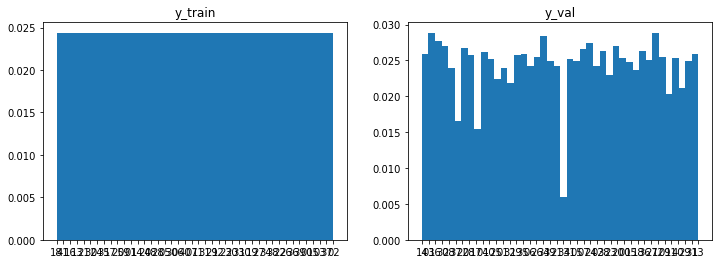

In [ ]:
# compare density of splitting categories
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df_model['category'], density=True, bins=42)
plt.title("y_train")
plt.subplot(1,2,2)
plt.hist(df_val['category'], density=True, bins=42)
plt.title("y_val")
plt.show()

# Create model

In [ ]:
import tensorflow.keras.backend as K

def categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.25,ls=0.1, classes=42.0):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
        y_ls = (1 - α) * y_hot + α / classes
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
        ls    -- label smoothing parameter(alpha)
        classes     -- No. of classes
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
        ls    -- 0.1
        classes     -- 40
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        #label smoothing
        y_pred_ls = (1 - ls) * y_pred + ls / classes
        # Clip the prediction value
        y_pred_ls = K.clip(y_pred_ls, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred_ls)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred_ls), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [ ]:
if premodel_name == 'mnet':
    premodel = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False, input_shape=(image_size, image_size, 3),
        pooling='avg', weights='imagenet')

elif premodel_name == 'effnetb4':
    premodel = EfficientNetB4(
        include_top=False, input_shape=(image_size, image_size, 3),
        pooling='avg', weights='imagenet'
    )

elif premodel_name == 'effnetb7':
    premodel = EfficientNetB7(
        include_top=False, input_shape=(image_size, image_size, 3),
        pooling='avg', weights='imagenet'
    )
premodel.summary()

Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 320, 320, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 320, 320, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 320, 320, 48) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dwconv (DepthwiseConv2D (None, 320, 320, 48) 432         stem_activation[0][0]            
__________

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        premodel,
        tf.keras.layers.Dense(dense, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(dense, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(42, activation='softmax')
    ])

    model.layers[0].trainable = False
    model.compile(
        loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=42.0), 
        optimizer=optimizer, metrics=['acc'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 42)                10794     
Total params: 18,209,410
Trainable params: 535,594
Non-trainable params: 17,673,816
______________________________________

# Model training

In [ ]:

batch_size = batch_size
steps_per_epoch = int(df_model.shape[0]/batch_size)
validation_steps = int(df_val.shape[0]/batch_size)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)


def preprocess_input(img):
    
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    eraser = get_random_eraser(v_l=-1., v_h=1., pixel_level=True, p=eraser_prob)
    img = eraser(img)
    return img

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    df_model,
    directory=image_dir,
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

validation_generator = validation_datagen.flow_from_dataframe(
    df_val,
    directory=image_dir,
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Steps per epoch: 3937
Validation steps: 329
Found 126000 validated image filenames belonging to 42 classes.
Found 10540 validated image filenames belonging to 42 classes.


In [ ]:

start_time = time()
h = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    epochs=epochs,
    class_weight=class_weight, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_acc:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_acc')
    ]

    )


print("Wall time: ", time()-start_time)


Epoch 1/10
3937/3937 [==============================] - 13552s 3s/step - loss: 0.8775 - acc: 0.5840 - val_loss: 0.5626 - val_acc: 0.7173
Epoch 2/10
3937/3937 [==============================] - 12609s 3s/step - loss: 0.7345 - acc: 0.6368 - val_loss: 0.5373 - val_acc: 0.7291
Epoch 3/10
3937/3937 [==============================] - 13234s 3s/step - loss: 0.7037 - acc: 0.6499 - val_loss: 0.5234 - val_acc: 0.7307
Epoch 4/10
3937/3937 [==============================] - 12476s 3s/step - loss: 0.6806 - acc: 0.6576 - val_loss: 0.5047 - val_acc: 0.7311
Epoch 5/10
3937/3937 [==============================] - 12444s 3s/step - loss: 0.6687 - acc: 0.6644 - val_loss: 0.5078 - val_acc: 0.7306
Epoch 6/10
3937/3937 [==============================] - 12384s 3s/step - loss: 0.6541 - acc: 0.6677 - val_loss: 0.5054 - val_acc: 0.7324
Epoch 7/10
3937/3937 [==============================] - 12596s 3s/step - loss: 0.6495 - acc: 0.6706 - val_loss: 0.4965 - val_acc: 0.7473
Epoch 8/10
3937/3937 [===================

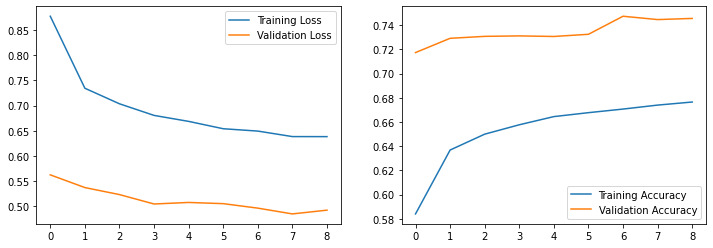

Loss: 0.6385
Acc: 0.6764
Val Loss: 0.4925
Val Accs: 0.7455


In [ ]:
losses = h.history['loss']
accs = h.history['acc']
val_losses = h.history['val_loss']
val_accs = h.history['val_acc']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

print("Loss: {:.4f}".format(losses[-1]))
print("Acc: {:.4f}".format(accs[-1]))
print("Val Loss: {:.4f}".format(val_losses[-1]))
print("Val Accs: {:.4f}".format(val_accs[-1]))

# Visualize validations

Displaying first 8 examples..


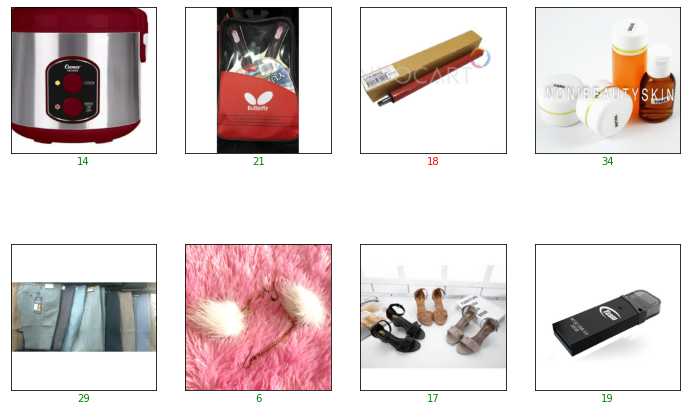

In [ ]:
x, y, images = get_random_batch(df_val, batch_size=8)
preds = model.predict(x).argmax(axis=1).reshape(-1,1)
display_examples(x, y, preds, images, df_val).show()

# Make prediction   

In [ ]:
# model.load_weights('models/model_0.686.h5')

In [ ]:
def create_prediction(df, batch_size=8, image_dir='test/test'):
    
    y = np.zeros((df.shape[0], 1))
    steps = int(df.shape[0]/batch_size)
    for i in range(0, steps+1):
        df_sub = df.loc[i*batch_size: (i+1)*batch_size].reset_index()
        if i == steps:
            batch_size = df.shape[0] % batch_size
        x = np.zeros((batch_size, image_size, image_size, 3))
        for j in range(0, batch_size):
            image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, df_sub.loc[j,'filename']), 
                                                            target_size=(image_size,image_size))
            arr = tf.keras.preprocessing.image.img_to_array(image)
            arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            arr = np.expand_dims(arr, axis=0)
            x[j] = arr
        if i == steps:
            y[-batch_size:] = model.predict(x).argmax(axis=1).reshape(-1,1)
        else:
            y[i*batch_size: (i+1)*batch_size] = model.predict(x).argmax(axis=1).reshape(-1,1)
    df['category'] = y
    df['category'] = df['category'].apply(lambda v: str(int(v)).zfill(2))
    return df
df_submit = create_prediction(df_test, batch_size=64)
df_submit

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [0]:
plt.hist(df_submit['category'], bins=42, density=True)
plt.show()

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [0]:
df_submit.to_csv('submit.csv', index=False)

KernelInterrupted: Execution interrupted by the Jupyter kernel.